In [8]:
## --- Load the StatGeochem package
using StatGeochem
using Plots

include("perplex_api.jl")

In [16]:
## --- Configure

# Absolute paths to perplex resources
perplexdir = joinpath(resourcepath,"perplex-stable")
scratchdir = "./output/" # Location of directory to store output files
println(resourcepath)

/root/resources


In [11]:
## --- # # # # # # # # # # # # # Initial composition # # # # # # # # # # # # # #

## McDonough Pyrolite
#elements =    [ "SIO2", "TIO2", "AL2O3",  "FEO",  "MNO",  "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [45.1242, 0.2005, 4.4623, 8.0723, 0.1354, 37.9043, 3.5598, 0.3610, 0.0291, 0.1511, 0.0440,]

## Kelemen (2014) primitive continental basalt. H2O and CO2 are guesses
#elements =    [ "SIO2", "TIO2", "AL2O3",  "FEO",  "MNO",  "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [50.0956, 0.9564, 15.3224, 8.5103, 0.1659, 9.2520, 9.6912, 2.5472, 0.8588, 2.0000, 0.6000,]

# Kelemen (2014) primitive continental basalt excluding Mn and Ti since most melt models can"t handle them..
#elements =    [ "SIO2", "AL2O3",  "FEO",  "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [50.0956, 15.3224, 8.5103, 9.2520, 9.6912, 2.5472, 0.8588, 2.0000, 0.6000,]

## Average Archean basalt (EarthChem data)
#elements =    [ "SIO2", "TIO2", "AL2O3",   "FEO",  "MNO",   "MGO",  "CAO", "NA2O",  "K2O",  "H2O",  "CO2",]
#composition = [49.2054, 0.8401, 12.0551, 11.4018, 0.2198, 12.3997, 9.3113, 1.6549, 0.4630, 1.8935, 0.5555,]

In [17]:
compositions = Dict(
    ## Hacker 2015 md xenolith
    "hacker_2015_md_xenolith"=> Dict(
        "index" => 1,
        "basis" => "wt",
        "elements" => [
            "NA2O",   
            "MGO",    
            "AL2O3",  
            "SIO2",   
            "CAO",    
            "FEO",
        ],
        "composition" => [
            2.60000,
            7.30000,
            17.0000,
            52.1000,
            10.3000,
            9.00000,
        ],
))

Dict{String, Dict{String, Any}} with 1 entry:
  "hacker_2015_md_xenolith" => Dict("composition"=>[2.6, 7.3, 17.0, 52.1, 10.3,…

In [23]:


SLB_solution_phases_all = "O\nPl\nSp\nCpx\nWad\nRing\nPv\nWus\nC2/c\nOpx\nAki\nPpv\nCF\nGt\nNaAl\n"
SLB_solution_phases_simple = "Pl\nCpx\nOpx\nGt\n"
SLB_excludes = ""

T_range_2d = (500+273.15, 1000+273.15) # Kelvin
P_range_2d = (5000, 25000) # bar

T_range_1d = (500+273.15,1000+273.15,)
P_range_1d = (25000, 5000)

T_surf = 273.15
melt_model = "melt(G)"

names = ["hacker_2015_md_xenolith"]
for name in names
    comp = compositions[name]
    perplex_build_vertex(perplexdir, scratchdir, comp["composition"], comp["elements"], P_range_2d, T_range_2d, 
        dataset="stx21ver.dat", 
        excludes=SLB_excludes,
        solution_phases=SLB_solution_phases_all, 
        composition_basis=comp["basis"], 
        mode_basis="vol", 
        name=name
    )

    modes = perplex_werami_profile(perplexdir, scratchdir, P_range_1d, T_range_1d, 
        name=name, 
    )
end

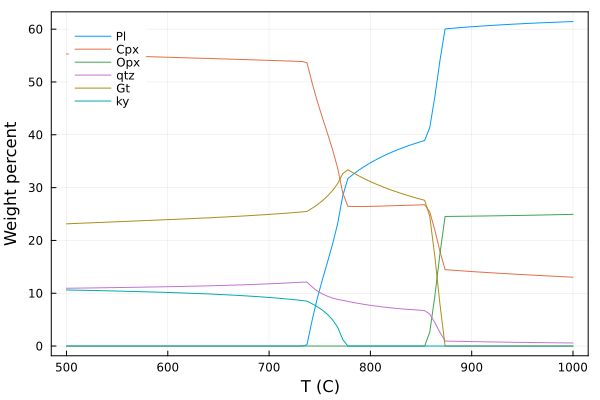

In [14]:
# Fix plag 
for m in modes["elements"][3:end]
    modes[m] = replace!(modes[m], NaN=>0.0)
end
modes["Pl"] = 100 .- (modes["qtz"] .+ modes["Opx"] .+ modes["ky"] .+ modes["Cpx"] .+ modes["Gt"])

h = plot(xlabel="T (C)", ylabel="Weight percent")

for m in modes["elements"][3:end]
    plot!(h, modes["T(K)"].-273.15, modes[m], label=m)
end
plot!(h,fg_color_legend=:white, framestyle=:box)
# savefig(h,"PhaseModes.pdf")
display(h)